In [1]:
import pathlib
from importlib import reload
import numpy as np
import torch
import matplotlib.pyplot as plt

import lab3
reload(lab3)

import lab3.classes
reload(lab3.classes)
import lab3.classes as cs

import lab3.show
reload(lab3.show)
from lab3.show import display_img_with_masks, display_masks

import lab3.trans
reload(lab3.trans)
from lab3.trans import validation_trans, train_trans, test_trans, to_tensor

import lab3.dataset
reload(lab3.dataset)
from lab3.dataset import FiftyOneDataset

import lab3.net
reload(lab3.net)
from lab3.net import Net

import lab1.device
reload(lab1.device)
from lab1.device import device

import lab3.util
reload(lab3.util)
from lab3.util import seconds_to_time

device

device(type='mps')

In [3]:
import os
from typing import Literal
import fiftyone as fo
import fiftyone.utils.openimages as fouo
import fiftyone.zoo as foz
import cv2

# COCO = {
#   "fo_type": fo.types.COCODetectionDataset,
#   "torch_ds": 
#   "short_name": "coco",
# }
# 
# FORMAT = COOC

def download_and_export(split ="train", max_samples: int = 2000):
  ds =  foz.load_zoo_dataset(
    "open-images-v6",
    split        = split,
    label_types  = ["segmentations"],
    classes      = cs.classes_no_background,
    max_samples  = max_samples,
    dataset_dir  = "data-lab3",
    dataset_name =f"open-images-v6-{split}"
  )
  
  # Print the schema of the dataset to inspect field names
  print("FIELD SCHEMA\n")
  print(ds.get_field_schema())
  
  # Print the labels of the first sample to see the available fields
  # first_sample = ds.first()
  # print(first_sample)
  
  # Possible formats:
  #  - COCODetectionDataset   | CocoDetection
  #  - VOCDetectionDataset    | VOCSegmentation
  ds.export(
    export_dir =f"data-lab3-voc/{split}",
    dataset_type = fo.types.VOCDetectionDataset,
    # label_field = "ground_truth",
    label_field = "segmentations",
    progress = True,
    classes=cs.classes_no_background
  )
  
  return ds

DOWNLOAD = True
if DOWNLOAD:
  download_and_export("train")
  download_and_export("validation", max_samples = 300)
  download_and_export("test", max_samples = 300)

Necessary images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'open-images-v6-train'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
FIELD SCHEMA

OrderedDict({'id': <fiftyone.core.fields.ObjectIdField object at 0x2dc6c1e50>, 'filepath': <fiftyone.core.fields.StringField object at 0x2daf7aa80>, 'tags': <fiftyone.core.fields.ListField object at 0x2daef1850>, 'metadata': <fiftyone.core.fields.EmbeddedDocumentField object at 0x2d9fd9310>, 'detections': <fiftyone.core.fields.EmbeddedDocumentField object at 0x107515a60>, 'segmentations': <fiftyone.core.fields.EmbeddedDocumentField object at 0x2df44b350>})


AttributeError: module 'fiftyone.types' has no attribute 'fiftyone'

In [3]:
def resize_dataset(path):
  for p in os.listdir(path):
    print('Img_filename : ', p)
    image = cv2.imread(path + p, cv2.IMREAD_UNCHANGED)
    # print(image)

    if image.shape[1] > image.shape[0]:
      scale = 128 / image.shape[0]
    else:
      scale = 128 / image.shape[1]

    width = int(image.shape[1] * scale)
    height = int(image.shape[0] * scale)
    dim = (width, height)

    # resize image
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_NEAREST)

    print('Resized Dimensions : ', dim)
    print('Resized Dimensions : ', resized.shape)
    break

RESIZE = False
if RESIZE:
  resize_dataset('data-lab3-coco/test/data/')
  resize_dataset('data-lab3-coco/validation/data/')
  resize_dataset('data-lab3-coco/train/data/')


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Image([[[0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
        [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
        [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
        ...,
        [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
        [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
        [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314]],

       [[0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
        [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
        [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
        ...,
        [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
        [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
        [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314]],

       [[0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
        [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 

KeyError: 'masks'

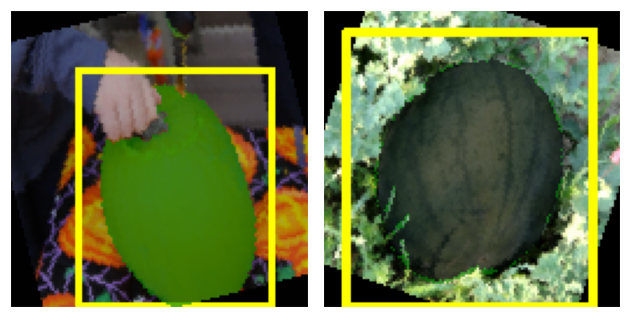

In [21]:
import torchvision.datasets as torch_ds
from torchvision.utils import draw_segmentation_masks
from lab3.util import plot
import torchvision.transforms.v2 as v2
import torchvision.transforms.v2 as trans
import torchvision.tv_tensors as tv_tensors


# sample = dataset[0]
# img, masks = sample
# masks

transforms = trans.Compose([
    trans.ToImage(),
    trans.Resize((128, 128)),
    trans.RandomHorizontalFlip(),
    trans.RandomRotation(20),
    trans.ColorJitter(brightness = 0.4, contrast = 0.2, saturation = 0.2, hue = 0.1),
    trans.RandomGrayscale(p = 0.1),
    v2.ToDtype(torch.float32, scale=True),
])

dataset = torch_ds.VOCSegmentation(
    "data-lab3-voc/test/data",
    "data-lab3-voc/test/labels.json",
    transforms=transforms
)

dataset = torch_ds.wrap_dataset_for_transforms_v2(
    dataset,
    target_keys=("boxes", "labels", "masks"),
)
sample = dataset[0]
plot([dataset[0], dataset[1]])
sample

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    # We need a custom collation function here, since the object detection
    # models expect a sequence of images and target dictionaries. The default
    # collation function tries to torch.stack() the individual elements,
    # which fails in general for object detection, because the number of bounding
    # boxes varies between the images of the same batch.
    collate_fn=lambda batch: tuple(zip(*batch)),
)


for imgs, targets in data_loader:
    print(imgs[0])
    print(targets[0]['masks'].shape)
    print(targets[0]['labels'])
    # print(targets[0])
    break


In [24]:
from torchvision.utils import draw_segmentation_masks
import torch.utils.data as tud
from torchvision.transforms import ToTensor
import os
import numpy as np
import torch
from PIL import Image
from pycocotools.coco import COCO
from pycocotools import mask as mask_utils
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as trans

train_trans = trans.Compose([
    trans.Resize((128, 128)),
    trans.RandomHorizontalFlip(),
    trans.RandomRotation(20),
    trans.ColorJitter(brightness = 0.4, contrast = 0.2, saturation = 0.2, hue = 0.1),
    trans.RandomGrayscale(p = 0.1),
    # to_tensor,
    trans.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# CocoSegmentationFiltered shamelessly stolen from ChatGPT
class CocoSegmentationFiltered(Dataset):
    def __init__(self, root, annFile, classes_of_interest, transform):
        self.root = root
        self.coco = COCO(annFile)
        self.ids = list(self.coco.imgs.keys())
        self.transform = transform

        # Retrieve class IDs for the classes of interest
        self.class_ids = self.coco.getCatIds(catNms=classes_of_interest)
        self.class_id_to_index = {cat_id: i for i, cat_id in enumerate(self.class_ids)}

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        img_info = coco.loadImgs(img_id)[0]
        path = os.path.join(self.root, img_info['file_name'])

        image = Image.open(path).convert('RGB')
        image = to_tensor(image)
        
        ann_ids = coco.getAnnIds(imgIds=img_id, catIds=self.class_ids, iscrowd=None)
        anns = coco.loadAnns(ann_ids)

        masks = np.zeros((
            len(self.class_ids),
            img_info['height'],
            img_info['width']),
            dtype=np.uint8)
        
        for ann in anns:
            if 'segmentation' in ann:
                cat_id = ann['category_id']
                if cat_id in self.class_id_to_index:
                    cat_index = self.class_id_to_index[cat_id]
                    rle = coco.annToRLE(ann)
                    m = mask_utils.decode(rle).astype(np.uint8)
                    masks[cat_index] = np.maximum(masks[cat_index], m)

        # masks = torch.as_tensor(masks, dtype=torch.uint8)
        image, masks = self.transform(image, masks)
        
        return image, masks

    def __len__(self):
        return len(self.ids)

BATCH_SIZE = 128

# Create an instance of the dataset
test_ds = CocoSegmentationFiltered(
  root="data-lab3-coco/test/data",
  annFile="data-lab3-coco/test/labels.json",
  transform = test_trans,
  classes_of_interest=cs.classes)

# Use DataLoader to load the dataset
test_dl = torch.utils.data.DataLoader(
  test_ds,
  batch_size = BATCH_SIZE,
  shuffle=False,
  collate_fn=lambda x: tuple(zip(*x))
  # collate_fn=lambda x: x
# collate_fn=lambda x: torch.tensor(list(zip(*x)))
)

# Create an instance of the dataset
train_ds = CocoSegmentationFiltered(
    root="data-lab3-coco/train/data",
    annFile="data-lab3-coco/train/labels.json",
    transform = train_trans,
    classes_of_interest=cs.classes)

# Use DataLoader to load the dataset
train_dl = torch.utils.data.DataLoader(
    train_ds,
    batch_size = BATCH_SIZE,
    shuffle=True,
    # collate_fn=lambda x: tuple(zip(*x))
    collate_fn=lambda x: list(zip(*x))
)

def show_image_and_masks(image, masks, classes_of_interest):
    image = image.permute(1, 2, 0).numpy() # Convert from (C, H, W) to (H, W, C)
    image = image[..., ::-1]
    
    fig, ax = plt.subplots(1, 1 + len(classes_of_interest), figsize=(15, 5))
    
    # Ensure the image has the correct dtype and scale
    if image.max() > 1:
        image = image / 255.0  # Scale to [0, 1] if the range is [0, 255]

    # Show the original image
    ax[0].imshow(image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Show the masks
    for i in range(len(classes_of_interest)):
        mask = masks[i].numpy()
        ax[i + 1].imshow(mask, cmap='gray')
        ax[i + 1].set_title(classes_of_interest[i])
        ax[i + 1].axis('off')
        # TODO: set dimensions

    plt.show()

# num_samples_to_show = 3
# for i, (image, masks) in enumerate(test_dl):
#     if i >= num_samples_to_show:
#         break
#     show_image_and_masks(image[0], masks[0], cs.classes)

# NUM_WORKERS = 8
# BATCH_SIZE  = 256
# 
# train_ds = make_dataset("train", train_trans)
# test_ds  = make_dataset("test",  test_trans)
# 
# train_dl =  tud.DataLoader(train_ds,
#   num_workers = NUM_WORKERS,
#   batch_size = BATCH_SIZE,
#   shuffle = True
# )
# 
# test_dl =  tud.DataLoader(
#   test_ds,
#   num_workers = NUM_WORKERS,
#   batch_size = BATCH_SIZE,
#   shuffle = False
# )
# 


# Iterate through the data
for imgs, masks in test_dl:
    print(masks[0].shape)
    print(masks[1].shape)
    print(masks[2].shape)
    # Do something with imgs and masks
    break


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
(5, 683, 1024)
(5, 768, 1024)
(5, 680, 1024)


In [ ]:
from statistics import mean
from sklearn.metrics import f1_score
from torch import tensor as t, concat as c

ZERO = torch.zeros(0, 6, 128, 128) < 1

class Stats:
  length = 0
  
  dice: float = 0
  iou:  float  = 0
  f1_micro: float = 0
  f1_macro: float = 0
  
  loss_acum: list[float] = []
  
  def init(self):
    pass
  
  def add_data(self, ys: torch.Tensor, y_hats: torch.Tensor, loss: float):
    # print(f"TYPE: {type(ys)}")
    # print(f"LEN:  {ys}")
    self.length += ys.shape[0]
    self.loss_acum.append(loss)

    intersection = torch.bitwise_and(ys, y_hats)
    union = torch.bitwise_or(ys, y_hats)

    intersection = torch.sum(intersection)
    union = torch.sum(union)

    # Jaccard = || A \intersect B || / || A \union B ||
    iou = intersection / union

    # DICE = 2 || A \intersect B || / (||A|| + ||B||)
    dice = 2 * intersection / (torch.sum(ys) + torch.sum(y_hats))

    # Flatten the tensors
    ys_flat = ys.view(-1).numpy()
    y_hats_flat = y_hats.view(-1).numpy()

    # Calculate Micro-F1 and Macro-F1 scores
    micro_f1 = f1_score(ys_flat, y_hats_flat, average='micro')
    macro_f1 = f1_score(ys_flat, y_hats_flat, average='macro')
    
    self.iou  += iou.item()
    self.dice += dice.item()
    self.f1_macro += macro_f1.item()
    self.f1_micro += micro_f1.item()
  
  def get_stats(self):
    return (
      self.iou / self.length, 
      self.dice / self.length,
      self.f1_micro / self.length,
      self.f1_macro / self.length,
      mean(self.loss_acum)
    )

def run_epoch(model: Net,
              loader: torch.utils.data.DataLoader,
              loss_fn, optimizer):
  stats = Stats()
  IS_TRAIN = optimizer is not None
  
  if IS_TRAIN:
    model.train()
  else:
    model.eval()

  ix = -1
  for images, true_masks in loader:
    print(len(images))
    print(len(true_masks))
    images = torch.tensor(images)
    true_masks = torch.tensor(true_masks)
    images = images.to(device)
    true_masks = true_masks.to(device)
    
    if not IS_TRAIN:
      with torch.no_grad():
        predictions = model(images)
    else:
      predictions = model(images)

    loss = loss_fn(true_masks, predictions)

    # print(f"  PRED_MAX: {predictions.max()}")
    predictions = predictions > 0.5
    true_masks = true_masks > 0.5
    stats.add_data(true_masks.cpu().detach(), predictions.cpu().detach(), loss.cpu().detach().item())
    
    if IS_TRAIN:
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    if ix == 0:
      break
    ix -= 1
  
  ret = stats.get_stats()
  return ret


In [ ]:
from datetime import datetime

def train_and_eval(model, train_ld, valid_ld, epoch_count = 10, learning_rate = 1e-3):
  loss_func = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

  start_time = datetime.now()

  train_loss_acum  = []
  train_iou_acum   = []
  train_dice_acum  = []
  train_micro_acum = []
  train_macro_acum = []
  valid_loss_acum  = []
  valid_iou_acum   = []
  valid_dice_acum  = []
  valid_micro_acum = []
  valid_macro_acum = []
  
  for epoch in range(epoch_count):
    print(f'EPOCH: {epoch + 1} / {epoch_count}')
    train_iou, train_dice, train_micro, train_macro, train_loss = run_epoch(model, train_ld, loss_func, optimizer)
    
    current_time = datetime.now()
    elapsed = seconds_to_time((current_time - start_time).total_seconds())
    print(f'  train      | Elapsed: {elapsed}')

    valid_iou, valid_dice, valid_micro, valid_macro, valid_loss = run_epoch(model, valid_ld, loss_func, optimizer)
    
    current_time = datetime.now()
    elapsed = seconds_to_time((current_time - start_time).total_seconds())
    print(f'  valid      | Elapsed: {elapsed}')

    train_iou_acum.append(train_iou)
    train_dice_acum.append(train_dice)
    train_micro_acum.append(train_micro)
    train_macro_acum.append(train_macro)
    train_loss_acum.append(train_loss)
    
    valid_iou_acum.append(valid_iou)
    valid_dice_acum.append(valid_dice)
    valid_micro_acum.append(valid_micro)
    valid_macro_acum.append(valid_macro)
    valid_loss_acum.append(valid_loss)

    print(f'  Training Loss:  {train_loss},  Validation Loss:  {valid_loss}')
    print(f'  Training IoU:   {train_iou},   Validation IoU:   {valid_iou}')
    print(f'  Training Dice:  {train_dice},  Validation Dice:  {valid_dice}')
    print(f'  Training Micro: {train_micro}, Validation Micro: {valid_micro}')
    print(f'  Training Macro: {train_macro}, Validation Macro: {valid_macro}')

  return train_iou_acum, valid_iou_acum, train_dice_acum, valid_dice_acum, train_micro_acum, valid_micro_acum, train_macro_acum, valid_macro_acum, train_loss_acum, valid_loss_acum

In [ ]:
def plot(train, valid, label = "IoU"):
  plt.clf()
  plt.plot(train, 'b', label = f'Training {label}')
  plt.plot(valid, 'r', label = f'Validation {label}')
  plt.ylim(0.0, 1.0)
  plt.legend()
  plt.show()

In [ ]:
# train_dataset[0]
# np.zeros(4).reshape((2, 2)).shape
img, t = test_ds[0]
t

In [ ]:
model = Net(test_ds[0][0].shape[0], num_classes = cs.num_classes).to(device)
print(f'Parameter count: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

EPOCHS = 100

train_iou, valid_iou, train_dice, valid_dice, train_micro, valid_micro, train_macro, valid_macro, train_loss, valid_loss = train_and_eval(
    model,
    train_dl,
    test_dl,
    epoch_count = EPOCHS,
    learning_rate = 1e-3
  )


In [ ]:
iter = train_dl.__iter__()
img: torch.Tensor; mask: torch.Tensor; prediction: torch.Tensor
imgs, masks = next(iter)

# prediction = model(img.unsqueeze(0).to(device)).cpu().detach().squeeze(0) img.shape, mask.unique(), mask.max()
# for i in range(10):
#   print(masks[0].max())

In [ ]:
plot(train_iou, valid_iou)
plot(train_dice, valid_dice, label = "dice")
plot(train_micro, valid_micro, label = "micro")
plot(train_macro, valid_macro, label = "macro")
plot(train_loss, valid_loss, label = "loss")


In [ ]:
torch.save(model, 'lab3/net_attempt2.pth')

In [ ]:
model = torch.load('lab3/net_attempt2.pth').to(device)

img, true_mask = valid_dataset[40]
prediction = model(img.unsqueeze(0).to(device)).cpu().detach().squeeze(0)

true_mask  = true_mask > .5
prediction = prediction > .5

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize= (7, 7))
display_img_with_masks(ax1, img, true_mask)
display_img_with_masks(ax2, img, prediction)
display_masks(ax3, true_mask)
display_masks(ax4, prediction)

# (
#   torch.max(true_mask),
#   torch.max(prediction),
# )
# (
#   torch.count_nonzero(true_mask),
# ),(
#   torch.count_nonzero(true_mask != .0),
#   (true_mask != .0).float()[0,0,0]
# )
# prediction.shape

In [ ]:
# t1 = t(
# # batch
# [
#   # masks for img 1
#   [
#     # mask for class 1
#     [[.2, .1], [.1, .3]],
#     # mask for class 2
#     [[.2, .1], [.1, .3]],
#     # mask for class 3
#     [[.2, .1], [.1, .3]],
#   ],
#   # masks for img 2
#   [
#     [[.2, .1], [.1, .5]],
#     [[.2, .1], [.1, .0]],
#     [[.2, .1], [.1, .3]],
#   ],
#   # masks for img 3
#   [
#     [[.2, .1], [.1, .0]],
#     [[.2, .1], [.1, .0]],
#     [[.2, .1], [.1, .3]],
#   ]
# ])
# 
# 
# # values, indices = t1.max(t([0, 2]))
# # (
# #   t1,
# #   values,
# #   (values ** (-1)) #.repeat(3) #.reshape((2, 3)) * t1
# # )
# 
# BATCH_SIZE = t(t1.shape)[0]
# CLASS_NO = t(t1.shape)[1]
# DIM = t(t1.shape)[2]
# 
# vals, ix = t1.max(dim = -1)[0].max(dim = -1)[0].max(dim = -1)
# vals = vals ** -1
# t2 = vals.repeat_interleave(CLASS_NO * DIM * DIM).view((BATCH_SIZE, CLASS_NO, DIM, DIM))
# (
#   # vals.repeat(CLASS_NO).reshape((CLASS_NO, 2)).transpose(dim0 = 0, dim1 = 1)
#     # .repeat((2, 3))
#   # vals.repeat(t1.shape)
#   t(t1.shape),
#   (BATCH_SIZE, CLASS_NO, DIM, DIM),
#   # vals.repeat(t(t1.shape)[:-1].flipud().tolist()).shape
#   vals,
#   BATCH_SIZE * CLASS_NO * DIM * DIM,
#   t(t1.shape).prod(),
#   t1 * t2,
#   # vals.repeat_interleave(BATCH_SIZE * CLASS_NO * DIM * DIM).shape,
#     # vals.repeat_interleave(t(t1.shape).tolist()).shape
#   # t1 * vals
#   # t1 * vals.repeat_interleave(BATCH_SIZE * CLASS_NO * DIM * DIM).view((2, 3, 2, 2, 2)),
#   # (t2 / t1)
#   # t2 / t1
# )